In [1]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV


import os
import numpy as np
import pickle
import copy
from itertools import product
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow_lattice as tfl

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
# import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [2]:
name = '2ActionsSplines'
log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
logs = os.listdir(log_path)
logs

['20201119-004840', '20201119-005231']

In [3]:
def construct_paths(log_num):
    models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num]))
    model_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num])
    env_path =  os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'env.pkl')
    try:
        buffer_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'buffer.pkl')
    except:
        print('No buffer found.')

    with open(buffer_path,'rb') as f:
        buffer = pickle.load(f)
    return model_path, buffer

model_path, buffer = construct_paths(1)
os.listdir(model_path)

['buffer.pkl', 'env.pkl', 'main_net.h5', 'train_config.pkl']

In [4]:
agent = DQNAgent.load(model_path)
agent.main_net.compile(loss='MSE')

[INFO] [2020-11-19 14:39:48,953] [C:\Projects\credit_collections_rl\learning\resources\models\2ActionsSplines\20201119-005231] - Instantiated class DQNAgent
[WARNING] [2020-11-19 14:39:49,466] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-11-19 14:39:49,477] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [5]:
def create_map(agent, lam_lim=7):
    w_points = 80
    l_points = 80
    l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
    w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)
    
#     w_normalized = np.linspace(0, 1, w_points)
#     l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
#     wwn, lln = np.meshgrid(w_normalized, l_normalized)
    ww, ll = np.meshgrid(w, l)
    space_iterator = product(l, w)
    space_product = agent.env.observation(np.array([[i, j] for i, j in space_iterator]))
    predictions = agent.main_net.predict_on_batch(space_product).numpy()
    z = np.amax(predictions, axis=1).reshape(l_points, w_points)
    p = np.argmax(predictions, axis=1).reshape(l_points, w_points)
    return  ww, ll, p, z
#ww, ll, aa, z = create_map(agent)
ww, ll, p, z = create_map(agent)

Text(0.5, 1.0, 'Simplest default with labels')

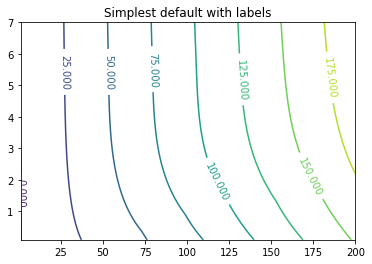

In [6]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


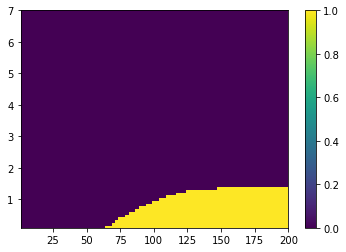

In [7]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

[INFO] [2020-11-19 14:40:20,966] [AAV] - Instantiated @ AAV
[INFO] [2020-11-19 14:40:20,985] [OAV] - Launching the value function procedure.
[INFO] [2020-11-19 14:40:20,987] [OAV] - Computing the value function on (0.00, 21.10].
[INFO] [2020-11-19 14:40:20,996] [OAV] - Computing the value function on (21.10, 23.45].
[INFO] [2020-11-19 14:40:22,067] [OAV] - Computing the value function on (23.45, 26.05].
[INFO] [2020-11-19 14:40:22,739] [OAV] - Computing the value function on (26.05, 28.95].
[INFO] [2020-11-19 14:40:23,381] [OAV] - Computing the value function on (28.95, 32.16].
[INFO] [2020-11-19 14:40:23,695] [OAV] - Computing the value function on (32.16, 35.73].
[INFO] [2020-11-19 14:40:24,375] [OAV] - Computing the value function on (35.73, 39.71].
[INFO] [2020-11-19 14:40:24,894] [OAV] - Computing the value function on (39.71, 44.12].
[INFO] [2020-11-19 14:40:25,360] [OAV] - Computing the value function on (44.12, 49.02].
[INFO] [2020-11-19 14:40:26,135] [OAV] - Computing the valu

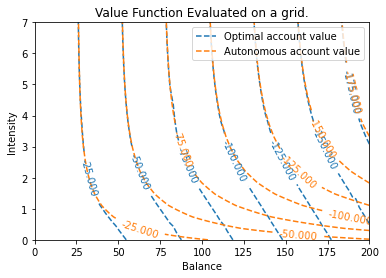

In [8]:
oav = OAV(agent.env.params, agent.env.w0, lmax=7)
oav.solve_v()
fig, ax = oav.plot_vf(plot_aav_flag=True)

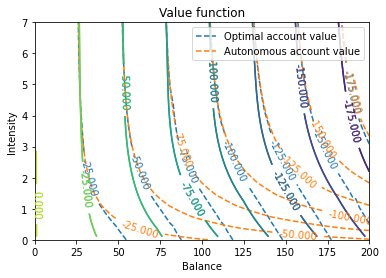

In [12]:
CS = ax.contour(ww, ll, -z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Value function')
fig

In [14]:
def get_frontier(ww, ll, aa):
    w_vector = ww[1, :]
    l_vector = ll[:, 1]
    lstars = np.zeros_like(w_vector)
    for i, w in enumerate(w_vector):
        try:
            l_star_index = np.max(np.nonzero(aa[:, i]))
            l_star = l_vector[l_star_index]
            lstars[i] = l_star
        except:
            lstars[i] = 0.0
    return w_vector, lstars

w_front, l_front = get_frontier(ww, ll, p)

NameError: name 'discrete_policy_opt' is not defined

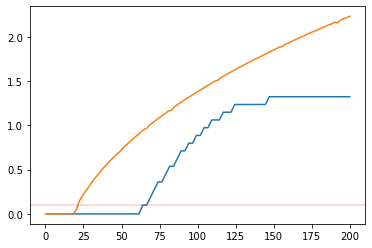

In [16]:
plt.plot(w_front, l_front)
plt.plot(oav.w_vector, oav.lambdastars)
plt.axhline(0.1, linewidth=0.3, color='red')